In [2]:
from desc.compute.utils import get_transforms, get_profiles, get_params, dot
from desc.compute import compute as compute_fun
from desc.backend import jnp
from desc.grid import Grid, LinearGrid
import desc.io
import desc.examples
from functools import partial
from jax import jit
from jax.experimental.ode import odeint as jax_odeint
import matplotlib.pyplot as plt
import numpy as np
import time
from desc.plotting import plot_surfaces, plot_section, plot_3d

# eq = desc.examples.get("DSHAPE")
eq = desc.io.load("equilibria/test_run.h5")
eq._iota = eq.get_profile("iota").to_powerseries(order=eq.L, sym=True)
eq._current = None
eq.solve()

def B_for_f_ratio_surface(psi_i):
    grid = LinearGrid(rho = np.sqrt(psi_i), M = 20, N = 20, NFP = eq.NFP)
    output = eq.compute("|B|", grid=grid)
    B = output["|B|"]
    return B

def B_for_f_ratio_fieldline(psi_i):
    coords = jnp.ones((250, 3)) #rho alpha zeta
    coords = coords.at[:, 0].set(coords[:, 0] * jnp.sqrt(psi_i))
    coords = coords.at[:, 2].set(jnp.linspace(0, 6 * jnp.pi, 250))

    start_time = time.time()
    print("starting map coords")
    print("--- %s seconds ---" % (time.time() - start_time))

    coords1 = eq.map_coordinates(
        coords=coords,
        inbasis=["rho", "alpha", "zeta"],
        outbasis=["rho", "theta", "zeta"],
        period=[jnp.inf, 2 * jnp.pi, jnp.inf],
        guess=None,
    )  # (2 * jnp.pi / eq.NFP)],

    grid = Grid(coords1, jitable=False, sort=False)
    output = eq.compute("|B|", grid=grid)

    B = output["|B|"]
    return B, coords1

def f_ratio(B):
    return np.sqrt(1-np.nanmin(B)/np.nanmax(B))




DESC version 0+untagged.5332.g4cefce1.dirty,using JAX backend, jax version=0.4.14, jaxlib version=0.4.14, dtype=float64
Using device: CPU, with 1.84 GB available memory
Building objective: force
Precomputing transforms
Compiling objective function and derivatives: ['force']
Number of parameters: 856
Number of objectives: 5346
Starting optimization
Using method: lsq-exact
Optimization terminated successfully.
`ftol` condition satisfied.
         Current function value: 2.734e-06
         Total delta_x: 6.469e-02
         Iterations: 5
         Function evaluations: 9
         Jacobian evaluations: 6
Start of solver
Total (sum of squares):  2.876e-06, 
Total force:  1.355e+05 (N)
Total force:  2.398e-03 (normalized)
End of solver
Total (sum of squares):  2.734e-06, 
Total force:  1.321e+05 (N)
Total force:  2.338e-03 (normalized)


In [3]:
def check(quantity, rho_i, theta_i, zeta_i):
    grid = Grid(jnp.array([rho_i, theta_i, zeta_i]).T, jitable=True, sort=False)
    output = eq.compute(quantity, grid=grid)
    return output[quantity]

# plot_3d(eq, "B")
val = check("grad(psi)", 1, 0, 0)[0]
print(val)

[ 1.57992279e+01 -3.24372694e-16  7.48118656e-16]


In [4]:
def system(w, t, a):
    #initial conditions
    psi, theta, zeta, vpar = w
    
    keys = ["B", "|B|", "grad(|B|)", "grad(psi)", "e^theta", "e^zeta", "b"] # etc etc, whatever terms you need
    grid = Grid(jnp.array([jnp.sqrt(psi), theta, zeta]).T, jitable=True, sort=False)
    transforms = get_transforms(keys, eq, grid, jitable=True)
    profiles = get_profiles(keys, eq, grid, jitable=True)
    params = get_params(keys, eq)
    data = compute_fun(eq, keys, params, transforms, profiles)
    
    psi = psi/(2*np.pi)
    E, m_q, bound_psi = a
    m = m_q*1.6e-19

    #b = (data["B"]/data["|B|"]) 
    mu = E/(m*data["|B|"]) - (vpar**2)/(2*data["|B|"])
    
    aux = data["b"] + m_q*(mu/data["|B|"]**2)*jnp.cross(data["B"], data["grad(|B|)"], axis=-1)/vpar

    psidot = m_q*(1/(data["|B|"]**3))*(mu*data["|B|"] + vpar**2) * jnp.sum(jnp.cross(data["B"], data["grad(|B|)"], axis = -1) * data["grad(psi)"])  
    thetadot = (vpar/data["|B|"]) * jnp.sum(data["B"] * data["e^theta"]) + (m_q/(data["|B|"]**3))*(mu*data["|B|"] + vpar**2)*jnp.sum(jnp.cross(data["B"], data["grad(|B|)"], axis=-1) * data["e^theta"])
    zetadot = (vpar/data["|B|"]) * jnp.sum(data["B"]* data["e^zeta"]) 
    vpardot = -mu*jnp.sum(aux * data["grad(|B|)"])

    return jnp.array([psidot/bound_psi, thetadot, zetadot, vpardot])

In [5]:
def run(E_, q_, bound_psi, m_, t_i, t_f, nt_ ,psi_i, theta_i, zeta_i, vpar_i_ratio):
    e_charge = q_*1.6e-19
    m = m_*1.673e-27
    tmin = t_i
    tmax = t_f
    nt = nt_
    E = E_*3.52e6*e_charge
    m_q = m/e_charge

    v_parallel = vpar_i_ratio*jnp.sqrt(2*E/m)
    a_initial = [E, m_q, bound_psi]
    initial_conditions = [psi_i, theta_i, zeta_i, v_parallel]

    def solve_with_jax(a=None):
        initial_conditions_jax = jnp.array(initial_conditions, dtype=jnp.float64)
        a_jax = jnp.array(a_initial, dtype=jnp.float64)
        t_jax = jnp.linspace(tmin, tmax, nt)
        system_jit = jit(system)
        solution_jax = jax_odeint(partial(system_jit, a=a_jax), initial_conditions_jax, t_jax)
        return solution_jax
    
    sol = solve_with_jax()
    print(sol)

    return sol

In [6]:
E_ = 1
q_= 1
m_ = 1
t_i = 0 
t_f = 0.00007
nt_ = 200


# psi_i = coords1[min_index, 0]**2
# theta_i = coords1[min_index, 1]
# zeta_i = coords1[min_index, 2]

psi_i = 0.7
theta_i = 0.2
zeta_i = 0.2
bound_psi = check("psi", 1, theta_i, zeta_i)[0]

# B_ = B_for_f_ratio_surface(psi_i=psi_i)
f = f_ratio(B_for_f_ratio_surface(psi_i=psi_i))

print(psi_i, theta_i, zeta_i)

vpar_i_ratio = 0.7*f
print(vpar_i_ratio)
sol = run(E_, q_, bound_psi, m_, t_i, t_f, nt_, psi_i, theta_i, zeta_i, vpar_i_ratio)

0.7 0.2 0.2
0.24074592089559677


2023-09-04 17:30:18.507614: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit__odeint_wrapper] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-09-04 17:31:30.646177: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 3m12.146689534s

********************************
[Compiling module jit__odeint_wrapper] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


[[ 7.00000000e-01  2.00000000e-01  2.00000000e-01  6.24679549e+06]
 [ 6.97759190e-01  2.44438990e-01  3.09918283e-01  6.19323866e+06]
 [ 6.95212543e-01  2.87840100e-01  4.21926190e-01  6.17069485e+06]
 [ 6.92225008e-01  3.28713292e-01  5.36959880e-01  6.11917424e+06]
 [ 6.88713285e-01  3.64018618e-01  6.54849108e-01  6.04088368e+06]
 [ 6.84946470e-01  3.99024893e-01  7.76345238e-01  6.00665513e+06]
 [ 6.80775539e-01  4.40009317e-01  9.01840768e-01  5.93306605e+06]
 [ 6.76095922e-01  4.82066919e-01  1.03009115e+00  5.83946062e+06]
 [ 6.71173857e-01  5.24491067e-01  1.16107591e+00  5.78445436e+06]
 [ 6.65877473e-01  5.79015971e-01  1.29369535e+00  5.68462945e+06]
 [ 6.60224314e-01  6.41120758e-01  1.42606745e+00  5.59625794e+06]
 [ 6.54286888e-01  6.94794164e-01  1.55738686e+00  5.51309948e+06]
 [ 6.47989293e-01  7.44357949e-01  1.68544444e+00  5.37941699e+06]
 [ 6.41527339e-01  7.96267226e-01  1.80907275e+00  5.28807877e+06]
 [ 6.34849427e-01  8.38995774e-01  1.92804426e+00  5.19168718e

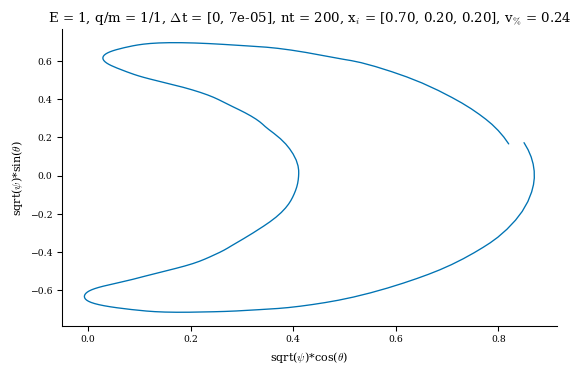

In [9]:
plt.plot(np.sqrt(sol[:, 0]) * np.cos(sol[:, 1]), np.sqrt(sol[:, 0]) * np.sin(sol[:, 1]))
plt.xlabel(r'sqrt($\psi$)*cos($\theta$)')
plt.ylabel(r'sqrt($\psi$)*sin($\theta$)')
plt.title(rf'E = {E_}, q/m = {q_}/{m_}, $\Delta$t = [{t_i}, {t_f}], nt = {nt_}, x$_i$ = [{psi_i:.2f}, {theta_i:.2f}, {zeta_i:.2f}], v$_\%$ = {vpar_i_ratio:.2f}')
plt.show()

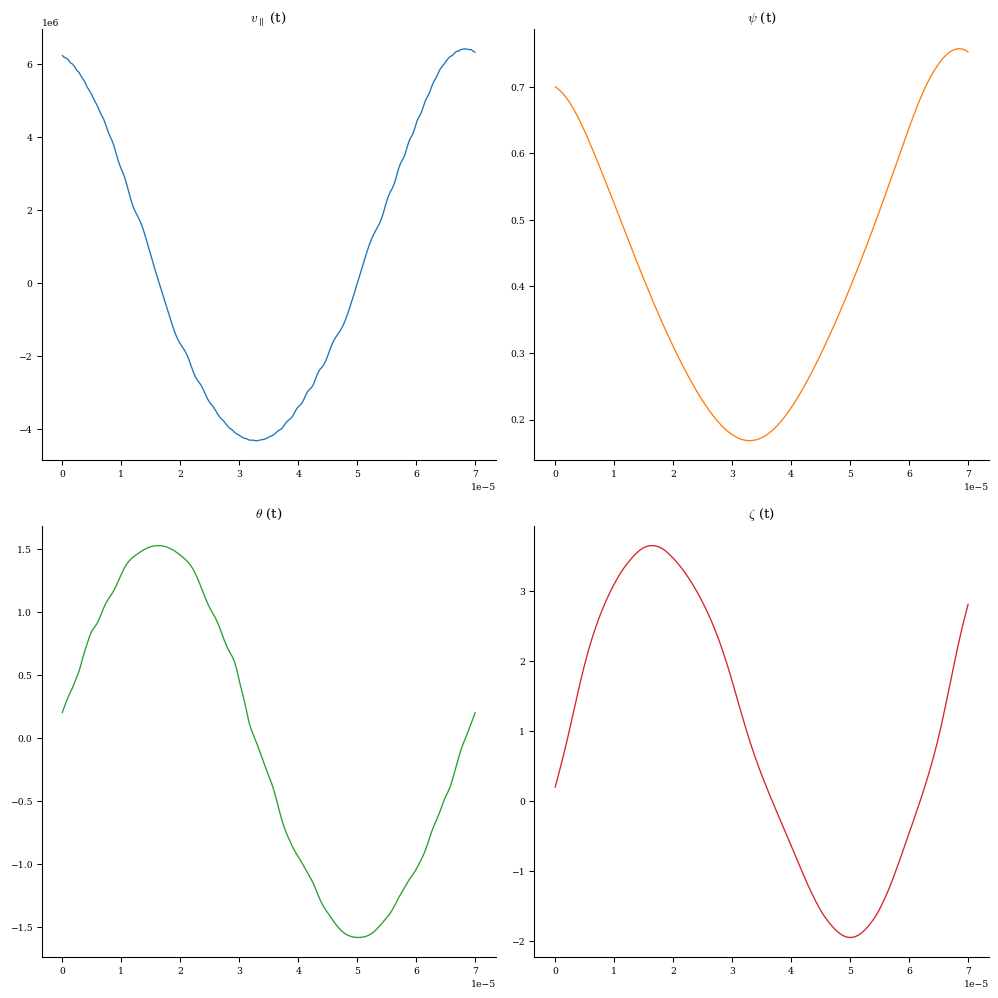

In [10]:
t = np.linspace(t_i, t_f, nt_)
fig, axs = plt.subplots(2, 2)
axs[0, 1].plot(t, sol[:, 0], 'tab:orange')
axs[0, 1].set_title(r'$\psi$ (t)')
axs[1, 0].plot(t, sol[:, 1], 'tab:green')
axs[1, 0].set_title(r'$\theta$ (t)')
axs[1, 1].plot(t, sol[:, 2], 'tab:red')
axs[1, 1].set_title(r'$\zeta$ (t)')
axs[0, 0].plot(t, sol[:, 3], 'tab:blue')
axs[0, 0].set_title(r"$v_{\parallel}$ (t)")

fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)

In [17]:
def energy(solution, nt_):
    grid = LinearGrid(rho=jnp.sqrt(2*jnp.pi*solution[:, 0]), theta=solution[:, 1], zeta=solution[:, 2])
    data = eq.compute("|B|", grid=grid)
    print(data["|B|"])
    E = np.ones(nt_)
    for i in range(0, nt_):
        E[i] = 0.5*(solution[i, 3]**2) 


: 